### This Notebooks contains lexical exploration

In [1]:
!pip install emoji
!pip install emosent-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


#### Loading Libs

In [2]:
import sys
sys.path.append("../libs/leia/")
from leia import SentimentIntensityAnalyzer
import pandas as pd
import emoji
from emosent import get_emoji_sentiment_rank
from datetime import datetime

#### Loading Classifiers

In [3]:
leia_classifier = SentimentIntensityAnalyzer()

#### Custom functions

In [4]:
def remove_duplicate_emoji(orig_str):
    prev_emoji = None
    remove_duplicate_emoji = []
    try:
        for c in orig_str:
            if c in emoji.EMOJI_DATA.keys():
                if prev_emoji == c:
                    continue
                prev_emoji = c
            remove_duplicate_emoji.append(c)
        return "".join(remove_duplicate_emoji)
    except:
        return orig_str

def check_emoji_sentiment(orig_str):
    neg = 0
    neu = 0
    pos = 0
    
    try:
        emoji_list = emoji.distinct_emoji_list(orig_str)
        if len(emoji_list) > 0:
            for item in emoji_list:
                
                try:
                    sentiment_rank = get_emoji_sentiment_rank(item)
                    neg += sentiment_rank['negative']
                    neu += sentiment_rank['neutral']
                    pos += sentiment_rank['positive']
                
                except:
                    pass
        
        tot = neg + neu + pos 
        
        return {
            'neg': round(neg/tot,3),
            'neu': round(neu/tot,3),
            'pos': round(pos/tot,3)
        }
    
    except:
        return {
            'neg': round(neg,3),
            'neu': round(neu,3),
            'pos': round(pos,3)
        }

def check_text_sentiment(orig_str):
    orig_str_without_emoji =  emoji.replace_emoji(remove_duplicate_emoji(orig_str), replace='')
    sentiment_polarity = leia_classifier.polarity_scores(orig_str_without_emoji)
    
    return {
            'neg': sentiment_polarity['neg'],
            'neu': sentiment_polarity['neu'],
            'pos': sentiment_polarity['pos']
    }

def compound_sentiment(text_sentiment, emoji_sentiment):
    compound = {
        'neg': 0,
        'neu': 0,
        'pos': 0
    }
    tot = 0
    for kind in compound.keys():
        compound[kind] = text_sentiment[kind] + emoji_sentiment[kind]
        tot += compound[kind]
    return {k: round(v / tot,3) for k, v in compound.items()}

In [5]:
df_tweets = pd.read_csv('../src/application/data/tweets_brazil.csv', sep=',')

#### Pre-processing

Removing excessive `emojis`

In [6]:
df_tweets['text'] = df_tweets['text'].apply(lambda x: remove_duplicate_emoji(x))

Splitting sentiment between `emojis` and `text`

`emoji`

In [7]:
df_tweets['emojis_sentiment'] = df_tweets['text'].apply(
    lambda x: check_emoji_sentiment(str(x))
)

`text`

In [8]:
df_tweets['text_sentiment'] = df_tweets['text'].apply(
    lambda x: check_text_sentiment(str(x))
)

`compound`

In [9]:
df_tweets['compound'] = df_tweets.apply(
    lambda x: compound_sentiment(x['text_sentiment'], x['emojis_sentiment']), axis=1
)

#### Split data between `neutral` and `lex_on=neg/pos`

In [10]:
df_tweets['neutral'] = df_tweets.apply(
    lambda x: True if x['compound'] == {'neg': 0.0, 'neu': 1.0, 'pos': 0.0} else False, axis=1
)

Proportion

26 | INFO | generated new fontManager


<AxesSubplot:ylabel='neutral'>

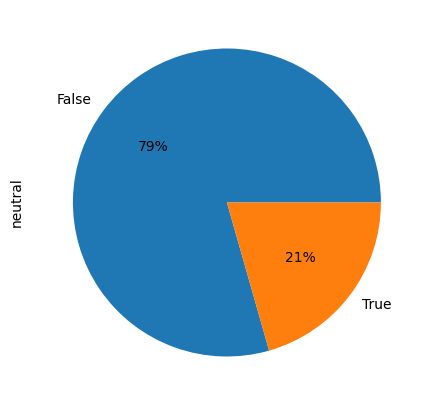

In [11]:
df_tweets.groupby(['neutral'])['neutral'].count().plot.pie(y='neutral', autopct='%1.0f%%', figsize=(5, 5))

`neutral`

In [12]:
df_neutral = df_tweets[df_tweets['neutral'] == True].reset_index(drop=True).copy()

`lex_on`

In [13]:
df_lex = df_tweets[df_tweets['neutral'] == False].reset_index(drop=True).copy()

`polarity`

In [14]:
df_lex['polarity'] = df_lex.apply(
    lambda x: "pos" if x['compound']['pos'] >= x['compound']['neg'] else "neg", axis=1
)

<AxesSubplot:ylabel='polarity'>

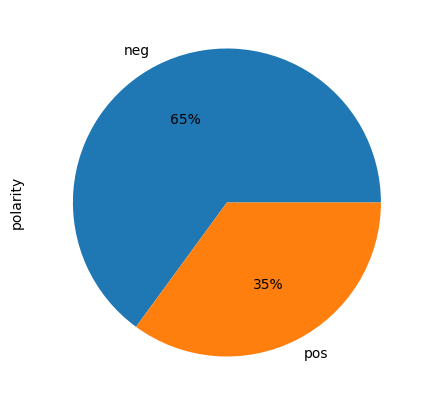

In [15]:
df_lex.groupby(['polarity'])['polarity'].count().plot.pie(y='polarity', autopct='%1.0f%%', figsize=(5, 5))

Creating `date`

In [16]:
df_lex['year'] = df_lex['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y') if isinstance(x, str) else 0
)

In [17]:
df_lex['month'] = df_lex['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%m') if isinstance(x, str) else 0
)

In [18]:
df = df_lex.groupby(['year', 'month', 'polarity'])['polarity'].agg(['count'])[1:].unstack('polarity').reset_index()

In [19]:
df.columns = ['year', 'month', 'neg', 'pos']

In [20]:
df[['neg', 'pos']] = df[['neg', 'pos']].divide(df[['neg', 'pos']].sum(axis=1), axis=0).fillna(0)[1:]

In [21]:
df = df.fillna(0)[1:]

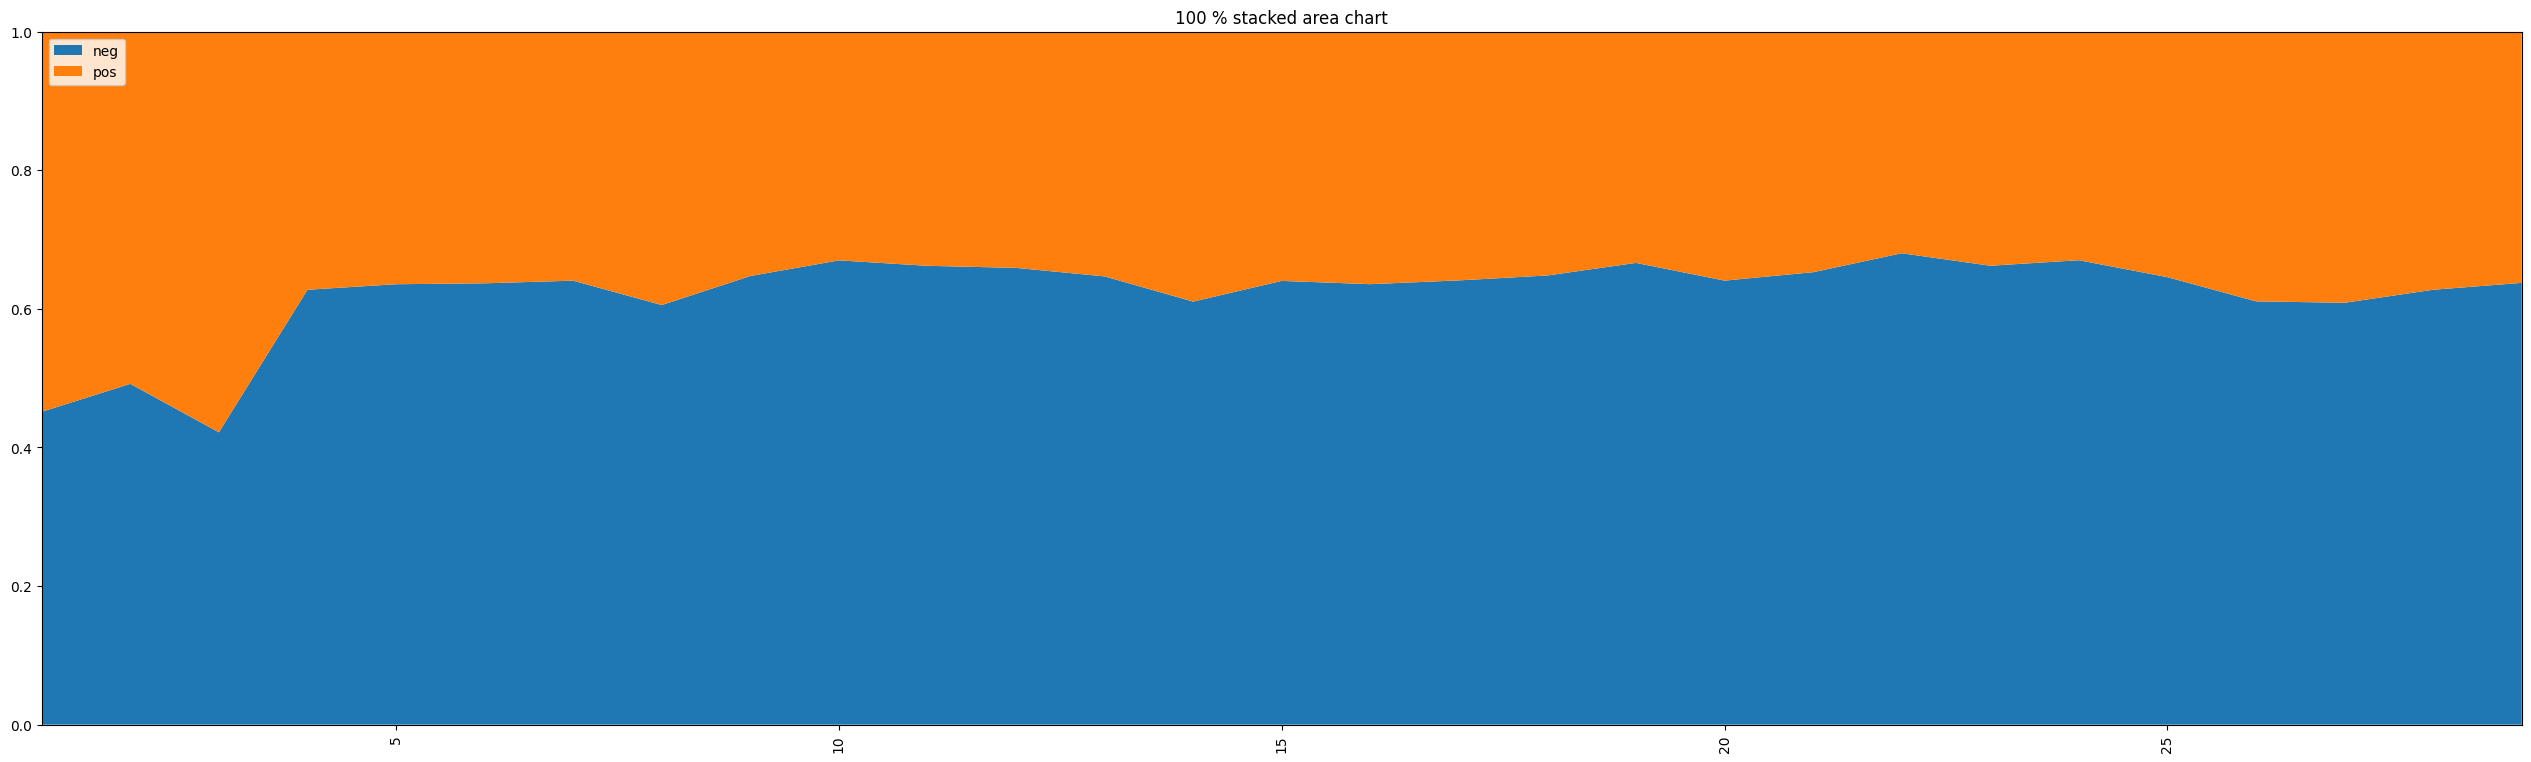

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = [32, 9]
plt.stackplot(df.index,  df["neg"],  df["pos"], labels=['neg','pos'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('100 % stacked area chart')
plt.xticks(rotation=90)
plt.show()

Collecting `10`most `negative`

In [23]:
df_lex['neg_value'] = df_lex.apply(
    lambda x: x['compound']['neg'], axis=1
)

In [24]:
df_lex[['text', 'neg_value']].sort_values(by='neg_value', ascending=False)

,text,neg_value
325762,Ódio ódio ódio ódio ódio ódio ódio vírus idiota,0.970
325458,Ódio ódio ódio ódio ódio ódio ódio vírus idiota,0.970
203160,CORONA VÍRUS O MEU OVO...\n\nBLÁ BLÁ BLÁ BLÁ B...,0.932
143681,@Corona_Bot__ aí não pô :(,0.920
144019,@Corona_Bot__ aí não pô :(,0.920
...,...,...
1010958,@LiaDeSousa1 Se ele fosse teu pai o Brasil est...,0.000
1010959,Comece a semana celebrando e agradecendo. \n...,0.000
701724,"Comecei a rir no escritório só ouvi ""iiih já c...",0.000
294402,amostra grátis de foto do pé por causa do coro...,0.000


In [25]:
df_tweets.head()

,text,author_id,conversation_id,created_at,source,tweet_id,geo_id,retweet_count,reply_count,like_count,quote_count,in_reply_to_user_id,referenced_type,referenced_id,emojis_sentiment,text_sentiment,compound,neutral
0,no gente cês parece retardado de querer saber ...,2.800738e+09,1.168307e+18,2019-09-01 23:38:37,Twitter for Android,1.168307e+18,d9d978b087a92583,0.0,1.0,3.0,0.0,NaN,NaN,NaN,"{'neg': 0, 'neu': 0, 'pos': 0}","{'neg': 0.247, 'neu': 0.753, 'pos': 0.0}","{'neg': 0.247, 'neu': 0.753, 'pos': 0.0}",False
1,q vírus é esse vei 🤬😡,1.010376e+18,1.168306e+18,2019-09-01 23:35:29,Twitter for Android,1.168306e+18,d9d978b087a92583,2.0,0.0,1.0,0.0,NaN,NaN,NaN,"{'neg': 0.533, 'neu': 0.107, 'pos': 0.36}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}","{'neg': 0.267, 'neu': 0.553, 'pos': 0.18}",False
2,n posso toma duas corona q já fico feliz credo,2.969021e+09,1.168304e+18,2019-09-01 23:26:26,Twitter for Android,1.168304e+18,5722ff20ba67083b,0.0,2.0,1.0,0.0,NaN,NaN,NaN,"{'neg': 0, 'neu': 0, 'pos': 0}","{'neg': 0.0, 'neu': 0.631, 'pos': 0.369}","{'neg': 0.0, 'neu': 0.631, 'pos': 0.369}",False
3,era só uma corona geladinha agora poxa vida,6.329194e+07,1.168300e+18,2019-09-01 23:08:58,Twitter for Android,1.168300e+18,3b5c5c9c62f7c538,0.0,1.0,1.0,0.0,NaN,NaN,NaN,"{'neg': 0, 'neu': 0, 'pos': 0}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",True
4,@SuavinBrito To bebendo corona de leve brota,1.610376e+08,1.168298e+18,2019-09-01 23:04:25,Twitter for Android,1.168299e+18,97bcdfca1a2dca59,1.0,1.0,1.0,0.0,3.431821e+09,replied_to,1.168298e+18,"{'neg': 0, 'neu': 0, 'pos': 0}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",True
